参考：https://blog.csdn.net/dgvv4/article/details/124349963
使用循环神经网络LSTM完成时间序列预测，本文是针对单个特征的预测

### 导入工具包
这里使用GPU加速计算，加快网络的训练速度

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# 调用GPU加速
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 获取数据

In [2]:
#（1）获取数据，按时间间隔1h记录的电力数据
filepath = 'test_data\energy.csv'
data = pd.read_csv(filepath)
print(data.head())

         Datetime  AEP_MW
0  2004/10/1 1:00   12379
1  2004/10/1 2:00   11935
2  2004/10/1 3:00   11692
3  2004/10/1 4:00   11597
4  2004/10/1 5:00   11681


### 数据预处理

NameError: name 'train_num' is not defined

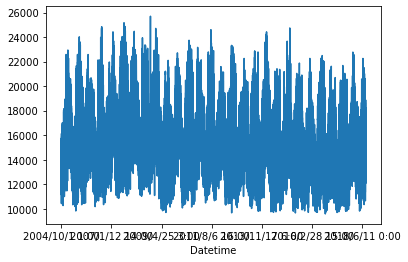

In [3]:
#（3）选择特征
temp = data['AEP_MW'] # 获取电力数据
temp.index = data['Datetime'] # 将索引改为时间序列
temp.plot()  # 绘图展示

### 划分数据集
首先，需要通过时间序列滑动窗口选择特征值及其对应的标签值。比如对某一时间点预测，规定每20个特征值，预测得到一个标签值。由于只有一列特征数据，相当于，用前20个数据预测第21个数据。同理对某一时间片段预测，用第1到20个数据预测第21到30的电量。

In [4]:
#（2）构建时间序列采样函数
'''
dataset为输入的特征数据，选取用哪些特征
start_index 这么多数据选择从哪个开始，一般从0开始取序列
history_size表示时间窗口大小；若为20，代表从起始索引开始找20个样本当作x，下一个索引当作y
target_size表示需要预测的结果时窗口后的第几个时间点；0表示下一时间点的预测结果，取其当作标签；若为一个序列，预测一个序列的指标
indices=range(i, i+history_size) 代表窗口序列的索引，i表示每个窗口的起始位置，窗口中所有数据的索引
'''
def database(dataset, start_index, end_index, history_size, target_size):
    data = []  # 存放特征值
    labels = []  # 存放目标值
    
    # 初始的取值片段[0:history_size]
    start_index = start_index + history_size
 
    # 如果不指定特征值终止索引，就取到最后一个分区前
    if end_index is None:
        end_index = len(dataset) - target_size
    
    # 遍历整个电力数据，取出特征及其对应的预测目标
    for i in range(start_index, end_index):
        indices = range(i - history_size, i) # 窗口内的所有元素的索引
        # 保存特征值和标签值
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size]) # 预测未来几个片段的天气数据
    # 返回数据集
    return np.array(data), np.array(labels)

In [5]:
# 取前90%个数据作为训练集
train_num = int(len(data) * 0.90)
# 90%-99.8%用于验证
val_num = int(len(data) * 0.998)
# 最后1%用于测试

#（4）对训练集预处理
temp_mean = temp[:train_num].mean()  # 均值
temp_std = temp[:train_num].std()  # 标准差
# 标准化
inputs_feature = (temp - temp_mean) / temp_std
 
#（5）划分训练集和验证集
# 窗口为20条数据，预测下一时刻气温
history_size = 20
target_size=0
 
# 训练集
x_train, y_train = database(inputs_feature.values, 0, train_num, 
                            history_size, target_size)
 
# 验证集
x_val, y_val = database(inputs_feature.values, train_num, val_num,
                          history_size, target_size)
 
# 测试集
x_test, y_test = database(inputs_feature.values, val_num, None,
                          history_size, target_size)
 
# 查看数据信息
print('x_train.shape:', x_train.shape)  # x_train.shape: (109125, 20, 1)

x_train.shape: (109125, 20, 1)


### 构造数据集
将划分好的numpy类型的训练集和验证集转换为tensor类型，用于网络训练。使用shuffle()函数打乱训练集数据，batch()函数指定每个step训练多少组数据。借助迭代器iter()使用next()函数从数据集中取出一个batch的数据用于验证。

In [6]:
#（6）构造tf数据集
# 训练集
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(10000).batch(128)
# 验证集
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(128) 
 
# 查看数据信息
sample = next(iter(train_ds))
print('x_batch.shape:', sample[0].shape, 'y_batch.shape:', sample[1].shape)
print('input_shape:', sample[0].shape[-2:])
# x_batch.shape: (128, 20, 1) y_batch.shape: (128,)
# input_shape: (20, 1)

x_batch.shape: (128, 20, 1) y_batch.shape: (128,)
input_shape: (20, 1)


### 模型构建
由于本案例数据量比较少，特征也只有一个，因此不需要使用复杂网络，使用一个LSTM层用于提取特征，一个全连接层用于输出预测结果。

In [7]:
# 构造输入层
inputs = keras.Input(shape=sample[0].shape[-2:])
# 搭建网络各层
x = keras.layers.LSTM(8)(inputs)
x = keras.layers.Activation('relu')(x)
outputs = keras.layers.Dense(1)(x)  # 输出结果是1个
# 构造模型
model = keras.Model(inputs, outputs)
# 查看模型结构
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 activation (Activation)     (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


### 网络训练
首先进行模型编译，使用adam优化器设置学习率0.01，使用平均绝对误差作为网络训练时的损失函数，网络迭代20次。回归问题不能设置metrics监控指标为准确率，这一般用于分类问题。

In [8]:
#（8）模型编译
opt = keras.optimizers.Adam(learning_rate=0.001)  # 优化器
 
model.compile(optimizer=opt, loss='mae')  # 平均误差损失
 
#（9）模型训练
epochs=20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
853/853 [==============================] - 7s 6ms/step - loss: 0.3736 - val_loss: 0.1265
Epoch 2/20
853/853 [==============================] - 5s 6ms/step - loss: 0.1141 - val_loss: 0.0784
Epoch 3/20
853/853 [==============================] - 5s 6ms/step - loss: 0.0888 - val_loss: 0.0713
Epoch 4/20
853/853 [==============================] - 5s 6ms/step - loss: 0.0832 - val_loss: 0.0699
Epoch 5/20
853/853 [==============================] - 5s 6ms/step - loss: 0.0804 - val_loss: 0.0660
Epoch 6/20
853/853 [==============================] - 5s 6ms/step - loss: 0.0768 - val_loss: 0.0649
Epoch 7/20
853/853 [==============================] - 5s 6ms/step - loss: 0.0752 - val_loss: 0.0634
Epoch 8/20
853/853 [==============================] - 5s 6ms/step - loss: 0.0739 - val_loss: 0.0623
Epoch 9/20
853/853 [==============================] - 5s 6ms/step - loss: 0.0732 - val_loss: 0.0612
Epoch 10/20
853/853 [==============================] - 5s 6ms/step - loss: 0.0723 - val_loss: 0.0632

### 查看训练信息
history变量中保存了训练过程的所有信息，我们绘制训练集损失和验证集损失曲线。

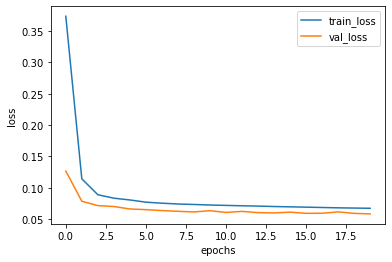

In [9]:
#（10）获取训练信息
history_dict = history.history  # 获取训练的数据字典
train_loss = history_dict['loss']  # 训练集损失
val_loss = history_dict['val_loss']  # 验证集损失
 
#（11）绘制训练损失和验证损失
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')  # 训练集损失
plt.plot(range(epochs), val_loss, label='val_loss')  # 验证集损失
plt.legend()  # 显示标签
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### 预测
对先前划分好的测试集进行预测，model中保存了网络训练好了的权重，使用 predict() 函数预测特征 x_test 分别对应的电量 y_predict，真实值 y_test，绘图展示预测值和真实值的偏离程度。也可以计算预测值和真实值之间的方差或标准差等指标来表明预测的准确性。

7/7 [==============================] - 0s 3ms/step


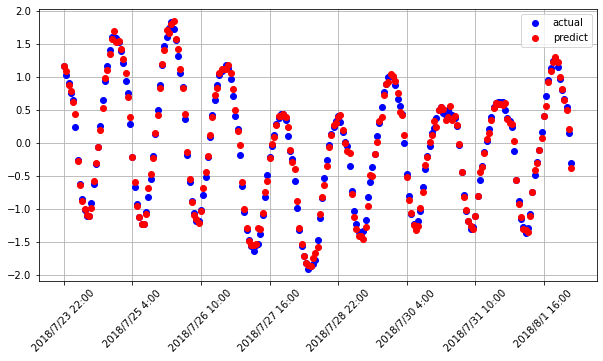

In [10]:
#（12）预测
y_predict = model.predict(x_test)  # 对测试集的特征值进行预测
 
# x_test 等同于经过预处理后的 temp[val_num:-20].values
dates = temp[val_num:-20].index  # 获取时间索引
 
#（13）绘制预测结果和真实值对比图
fig = plt.figure(figsize=(10,5))
# 真实值
axes = fig.add_subplot(111)
axes.plot(dates, y_test, 'bo', label='actual')
# 预测值，红色散点
axes.plot(dates, y_predict, 'ro', label='predict')
# 设置横坐标刻度
axes.set_xticks(dates[::30])
axes.set_xticklabels(dates[::30],rotation=45)
 
plt.legend()  # 注释
plt.grid()  # 网格
plt.show()